In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import json
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from os.path import join as path_join


def load_data(path):
    tasks = pd.Series()
    for file_path in os.listdir(path):
        task_file = path_join(path, file_path)

        with open(task_file, 'r') as f:
            task = json.load(f)

        tasks[file_path[:-5]] = task
    return tasks

In [3]:
train_tasks = load_data('/content/drive/My Drive/Colab Notebooks/project/abstraction-and-reasoning-challenge/training/')
evaluation_tasks = load_data('/content/drive/My Drive/Colab Notebooks/project/abstraction-and-reasoning-challenge/evaluation/')
test_tasks = load_data('/content/drive/My Drive/Colab Notebooks/project/abstraction-and-reasoning-challenge/test/')

train_tasks.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


0520fde7    {'train': [{'input': [[1, 0, 0, 5, 0, 1, 0], [...
08ed6ac7    {'train': [{'input': [[0, 0, 0, 0, 0, 5, 0, 0,...
00d62c1b    {'train': [{'input': [[0, 0, 0, 0, 0, 0], [0, ...
017c7c7b    {'train': [{'input': [[0, 1, 0], [1, 1, 0], [0...
025d127b    {'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0,...
dtype: object

In [0]:
import torch
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from torch.optim import Adam
from torch.nn import Conv2d
from torch import FloatTensor, LongTensor



def inp2img(inp):
    inp = np.array(inp)
    img = np.full((10, inp.shape[0], inp.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        img[i] = (inp==i)
    return img


class TaskSolver:        
    def train(self, task_train, n_epoch=30):
        """basic pytorch train loop"""
        self.net = Conv2d(in_channels=10, out_channels=10, kernel_size=5, padding=2)
        
        criterion = CrossEntropyLoss()
        optimizer = Adam(self.net.parameters(), lr = 0.1)
        
        for epoch in range(n_epoch):
            for sample in task_train:
                inputs = FloatTensor(inp2img(sample['input'])).unsqueeze(dim=0)
                labels = LongTensor(sample['output']).unsqueeze(dim=0)
                
                optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        return self
            
    def predict(self, task_test):
        predictions = []
        with torch.no_grad():
            for sample in task_test:
                inputs = FloatTensor(inp2img(sample['input'])).unsqueeze(dim=0)
                outputs = self.net(inputs)
                pred =  outputs.squeeze(dim=0).cpu().numpy().argmax(0)
                predictions.append(pred)
                                     
        return predictions

In [0]:
def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])

def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

In [0]:
def evaluate(tasks):
    ts = TaskSolver()
    result = []
    predictions = []
    for task in tqdm(tasks):
        if input_output_shape_is_same(task):
            ts.train(task['train'])
            pred = ts.predict(task['test'])
            score = calk_score(task['test'], pred)
        else:
            pred = [el['input'] for el in task['test']]
            score = [0]*len(task['test'])
        
        predictions.append(pred)
        result.append(score)
       
    return result, predictions

In [13]:
train_result, train_predictions = evaluate(train_tasks)
train_solved = [any(score) for score in train_result]

total = sum([len(score) for score in train_result])
print(f"solved : {sum(train_solved)} from {total} ({sum(train_solved)/total})")

100%|██████████| 400/400 [00:29<00:00, 13.42it/s]

solved : 11 from 416 (0.026442307692307692)


In [0]:
evaluation_result, evaluation_predictions = evaluate(evaluation_tasks)
evaluation_solved = [any(score) for score in evaluation_result]

total = sum([len(score) for score in evaluation_result])
print(f"solved : {sum(evaluation_solved)} from {total} ({sum(evaluation_solved)/total})")

100%|██████████| 400/400 [00:30<00:00, 12.92it/s]

solved : 4 from 419 (0.00954653937947494)


In [0]:
import matplotlib.pyplot as plt
from matplotlib import colors


cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
    
def plot_pictures(pictures, labels):
    fig, axs = plt.subplots(1, len(pictures), figsize=(2*len(pictures),32))
    for i, (pict, label) in enumerate(zip(pictures, labels)):
        axs[i].imshow(np.array(pict), cmap=cmap, norm=norm)
        axs[i].set_title(label)
    plt.show()
    

def plot_sample(sample, predict=None):
    if predict is None:
        plot_pictures([sample['input'], sample['output']], ['Input', 'Output'])
    else:
        plot_pictures([sample['input'], sample['output'], predict], ['Input', 'Output', 'Predict'])

0it [00:00, ?it/s]

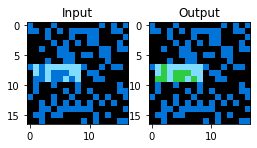

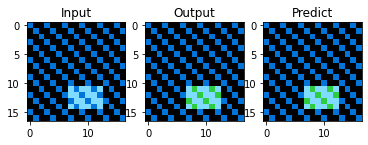

62it [00:00, 71.17it/s]

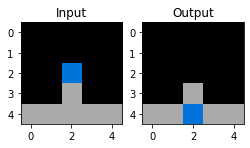

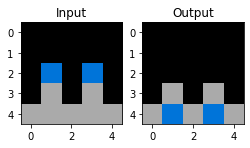

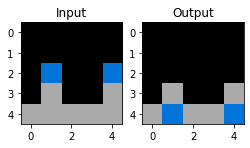

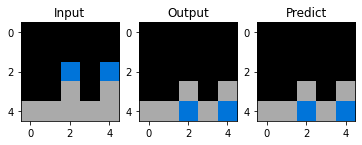

73it [00:01, 32.24it/s]

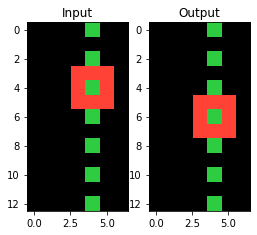

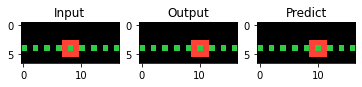

123it [00:02, 37.83it/s]

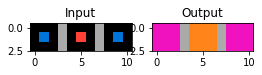

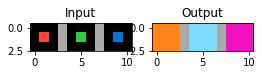

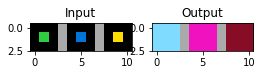

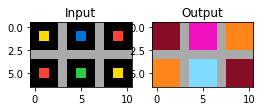

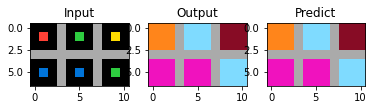

127it [00:03, 10.38it/s]

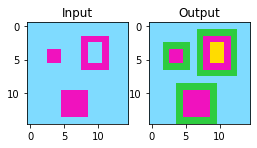

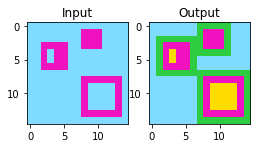

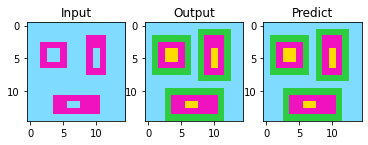

130it [00:04,  7.86it/s]

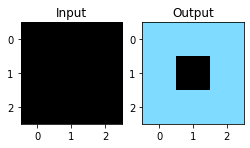

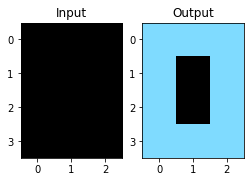

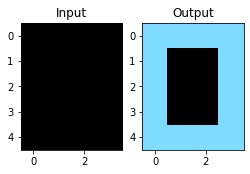

178it [00:05, 10.53it/s]

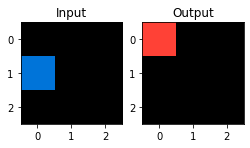

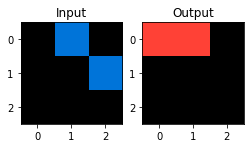

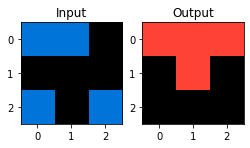

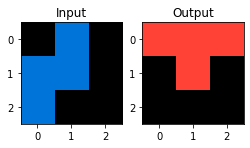

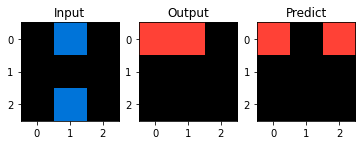

191it [00:07,  8.42it/s]

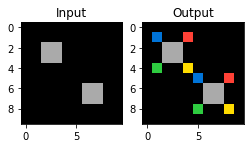

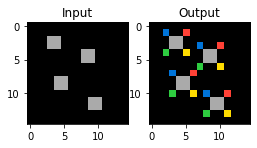

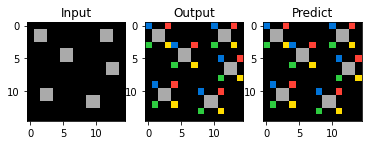

230it [00:08, 11.22it/s]

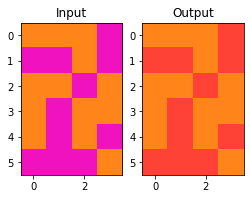

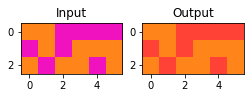

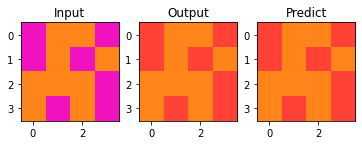

278it [00:08, 14.77it/s]

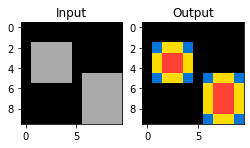

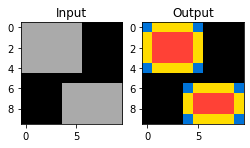

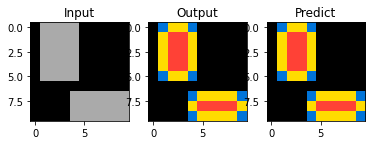

283it [00:09, 12.07it/s]

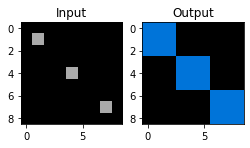

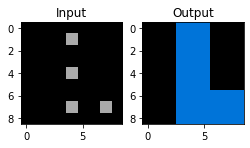

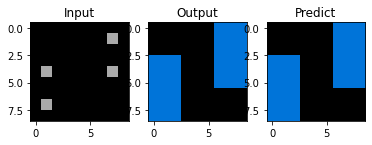

400it [00:10, 39.50it/s]


In [0]:
for task, prediction, solved in tqdm(zip(train_tasks, train_predictions, train_solved)):
    if solved:
        for i in range(len(task['train'])):
            plot_sample(task['train'][i])
            
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])